# Converting netCDF to Zarr


This notebook demonstrates the various tricks (hacks?) that I use when converting existing netCDF datasets to zarr datasets using xarray.
A key concept is the following: _many netCDF files will become one single zarr dataset._
You need to decide what are the individual zarr datasets you want to produce. This depends on the scientific application.
In general, for model simulations, my approach is to contatenate all the time snapshots of a specific file
(e.g. `01810101.ocean_bdy_flux.nc`, `01810201.ocean_bdy_flux.nc`) into a single zarr dataset.

The steps are as follows:

1. **Understand the structure and content of the netCDF files.** Make sure that the files you are trying to combine are actually consistent in terms of the variables they contain, coordinates, etc.
1. **Decide on input / output chunk sizes.** Chunks are a crucial parameter for performance in zarr. There is no universal rule for choosing chunk sizes. The choice depends on access patterns. Furthermore, the chunks of the source dataset (from netCDF files) don't necessarily have to match the target zarr dataset (although this is the easiest option.) The rule of thumb we have been using for now is that we want the compressed zarr chunks to approximately 10-100 MB.
1.  **Open the all the netCDF files using `xarray.open_mfdataset`.** I usually start by opening a single file first using `open_dataset`. For example, do you want to decode CF conventions? (Note that decoding is not strictly necessary; the encoding attributes will be passed along to zarr allowing the zarr dataset to be decoded later.) Do you want to drop certain variabiles? Trial and error is usually required to get the dataset to look right. If you want the chunking of the dataset to differ from xarray's default choice (one chunk per variable per file), you will also have to specifcy `chunks`.
1. **Define the extra encoding options for zarr.** This mostly means deciding what [zarr compressor](https://zarr.readthedocs.io/en/v2.1.3/tutorial.html#compressors) to use. Experimentation with different compression types and rates is encouraged.
1. **Export to zarr.** Once the above choices have been made, it is fairly trivial to actually export the dataset using xarray's [`to_zarr`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_zarr.html) method. This can take a long time. If sufficient temporary storage is available, I strongly recommend exporting the dataset first to a zarr directory store (files) before uploading to the cload.
1. **Upload to cloud storage.** Once the zarr directory store is finished writing, you can use your cloud provider's command line utilities to upload the files to cloud storage.

## Example: CM2.6 Ocean Surface Fields

The notebook below shows a real example of producing a dataset in zarr format.

Note that it is always recommended to use the latest versions of xarray and zarr for this, since the technology is evolving very fast.

In [1]:
import xarray as xr
from glob import glob
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
import zarr
from dask.diagnostics import ProgressBar

%matplotlib inline

In [2]:
zarr.__version__

'2.2.1.dev125'

In [3]:
xr.__version__

'0.11.1+19.gf13536c'

### Optional: Use a Dask Cluster

If the computer where you are producing the dataset can provide parallelism, it can speed things up a lot to use a dask cluster. Even if you are only using a small machine, using a distributed cluster is nice because it gives you lots of useful diagnostics and progress information via the dashboard.

For reference, the machine where this example was run is a large shared server with 36 Xeon CPU cores, 1TB of RAM, and ~400 TB of RAID-6 hard disk storage.

### Open Source NetCDF Files

Rather than using globbing to find the source files, here I am being more explicit about which files I want to open. This is recommended if know the pattern and conventions that were used to produce the source files.

In [4]:
experiment = 'one_percent'
base_dir = '/swot/SUM01/CM2.6'
ddir = os.path.join(base_dir, experiment)
prefix = 'ocean_trans'
year_start, year_end = 181, 200
years = np.arange(year_start, year_end+1)
year_str = '%04d-%04d' % (year_start, year_end)
files = [os.path.join(ddir, '%04d0101.%s.nc' % (year, prefix))
         for year in years]

In [5]:
files[:2]

['/swot/SUM01/CM2.6/one_percent/01810101.ocean_trans.nc',
 '/swot/SUM01/CM2.6/one_percent/01820101.ocean_trans.nc']

Here I define some more options related to opening the files. Specifically, I know I want to drop certain extraneous coordinates and auxilliary variables. 

**Performance tip:** Dropping coordinates when opening many files with xarray is generally a good idea, because xarray has to verify that the coordinates are identical in each file. The coordinates can then be added back to the concattenated dataset.

In [9]:
# these are variables I just want to drop forever
drop_vars = ['average_T1', 'average_T2', 'average_DT', 'time_bounds']
drop_vars += ['yt_ocean', 'xt_ocean', 'yu_ocean', 'xu_ocean',
              'grid_yu_ocean', 'grid_xu_ocean', 'grid_yt_ocean', 'grid_xt_ocean']
# therse are variables I want to drop while running `open_mfdataset` but then add back later
extra_coord_vars = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c']
chunks = {'time': 'auto', 'st_ocean': 5, 'potrho': 5}

open_kwargs = dict(drop_variables=(drop_vars + extra_coord_vars),
                   chunks=chunks, decode_cf=True, decode_times=False)
ds = xr.open_mfdataset(files, parallel=True, **open_kwargs)

# add the extra coordinates back in
ds0 = xr.open_dataset(files[0], decode_cf=True, decode_times=False)[extra_coord_vars]
for cv in extra_coord_vars:
    ds.coords[cv] = ds0.coords[cv]
ds

<xarray.Dataset>
Dimensions:                   (grid_xt_ocean: 3600, grid_yu_ocean: 2700, nv: 2, potrho: 80, potrho_edges: 81, st_edges_ocean: 51, st_ocean: 50, time: 240, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * nv                        (nv) float64 1.0 2.0
  * st_ocean                  (st_ocean) float64 5.034 15.1 ... 5.395e+03
  * st_edges_ocean            (st_edges_ocean) float64 0.0 10.07 ... 5.5e+03
  * potrho                    (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03
  * potrho_edges              (potrho_edges) float64 1.028e+03 ... 1.038e+03
  * time                      (time) float64 6.576e+04 6.579e+04 ... 7.303e+04
    geolat_t                  (yt_ocean, xt_ocean) float32 ...
  * yt_ocean                  (yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98
  * xt_ocean                  (xt_ocean) float64 -279.9 -279.8 ... 79.85 79.95
    geolon_t                  (yt_ocean, xt_ocean) float32 ...
    geolat_c                

Do a sanity check on the input data.

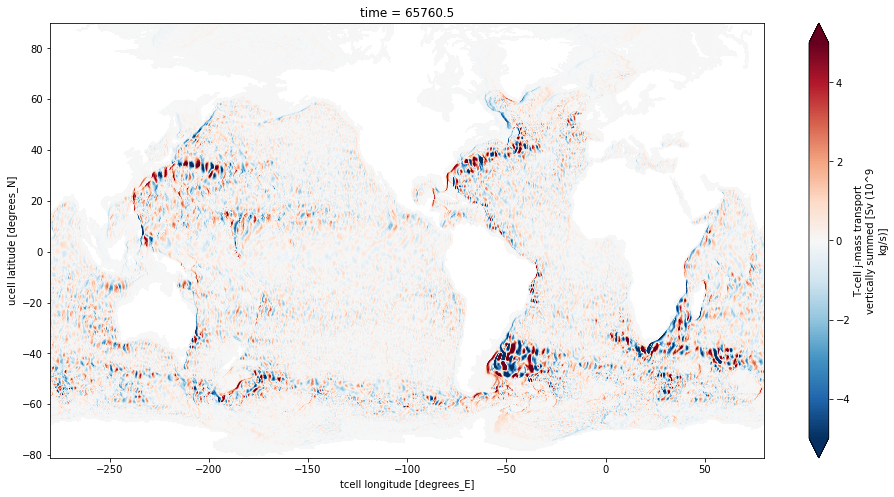

In [14]:
ds.ty_trans_int_z[0].load().plot(figsize=(16, 8), vmax=5)

### Export to Zarr

I also define a custom compressor to use.

In [19]:
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
encoding = {vname: {'compressor': compressor} for vname in ds.variables}
outdir_base = '/swot/SUM03/tmp/CM2.6'
dsname = prefix
outdir = os.path.join(outdir_base, experiment, dsname)
outdir

'/swot/SUM03/tmp/CM2.6/control/ocean_trans'

In [20]:
ds.nbytes / 1e9

2220.981275232

In [ ]:
with ProgressBar():
    zs = ds.to_zarr(outdir, encoding=encoding, consolidated=True)

[#                                       ] | 2% Completed |  4min  4.7s

### Verify Zarr Dataset

In [14]:
ds_z = xr.open_zarr(outdir, consolidated=True)
ds_z

<xarray.Dataset>
Dimensions:                   (grid_xt_ocean: 3600, grid_yu_ocean: 2700, nv: 2, potrho: 80, potrho_edges: 81, st_edges_ocean: 51, st_ocean: 50, time: 240, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
    geolat_c                  (yu_ocean, xu_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
    geolat_t                  (yt_ocean, xt_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
    geolon_c                  (yu_ocean, xu_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
    geolon_t                  (yt_ocean, xt_ocean) float32 dask.array<shape=(2700, 3600), chunksize=(338, 450)>
  * nv                        (nv) float64 1.0 2.0
  * potrho                    (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03
  * potrho_edges              (potrho_edges) float64 1.028e+03 ... 1.038e+03
  * st_edges_ocean            (st_edges_ocean) float64 0.0 10.07 ... 5.5e+03
  * st_ocean     

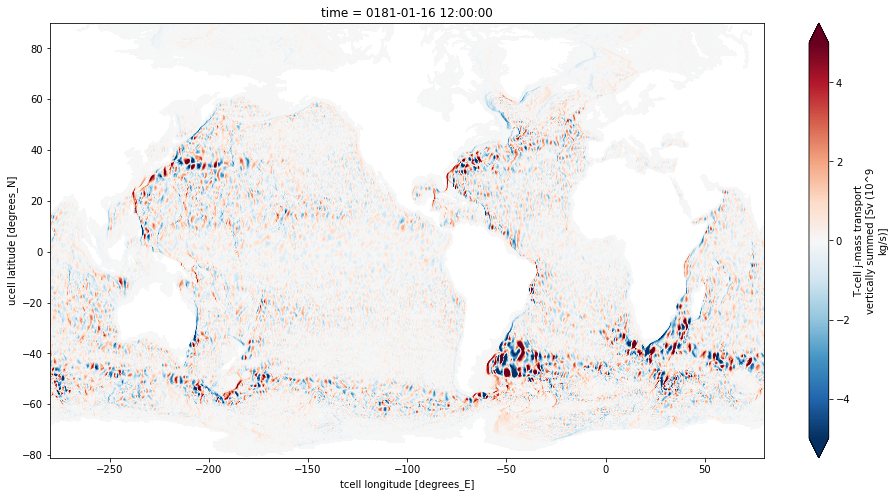

In [15]:
ds_z.ty_trans_int_z[0].load().plot(figsize=(16, 8), vmax=5)

Look at zarr's own diagnostic info for one of the variables. There is lots of useful info in here.

In [16]:
zstore = zs.ds
zstore.ty_trans.info

Name,/ty_trans
Type,zarr.core.Array
Data type,float32
Shape,"(240, 50, 2700, 3600)"
Chunk shape,"(1, 5, 2700, 3600)"
Order,C
Read-only,False
Compressor,"Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,466560000000 (434.5G)
No. bytes stored,187880976644 (175.0G)
